# Fine-tuning

Now that you've seen the power of Transformers models in many different forms, we're going to dig deeper with the HuggingFace library and focus a little more on understanding what is going on, and how we can use these models to improve on techniques we saw yesterday and last week. To that end, let's consider a task we've seen before - sentiment classification. 

### The Data

To get started, we're going to load up this [csv](https://wagon-public-datasets.s3.amazonaws.com/imdb.csv) of 8000 IMDB reviews that we're going to be using throughout this exercise.

Once you've loaded it up, check what kind of data we're dealing with and take some time to look through some of the examples in the DataFrame. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
url= 'https://wagon-public-datasets.s3.amazonaws.com/imdb.csv'
df= pd.read_csv(url)

In [11]:
df.head()

,text,label
0,Ouch! They don't come much worse than this hor...,0
1,Great little thriller. I was expecting some ty...,1
2,In this extremely low-budget ( I've seen home ...,0
3,I wouldn't say this is a *bad* movie. Unfortun...,0
4,"What were they thinking at ""Cannes""? One of th...",0


In [12]:
df['text'][2]

'In this extremely low-budget ( I\'ve seen home movies made with better production value) Australian utter rip-off of "the Burning" & "Friday the 13th", a band is planning to make a music video while on a houseboat. They\'re stalked by a serial killer who was burned years before. This movie is even proclaimed to be \'the worst Australian film ever made\' in it\'s DVD promotional material. That\'s it\'s only selling point! Complete and utter rubbish in every considerable way. Perhaps a few chuckles here and there for bad movie lovers, but it still made me want to burn out my retinas.<br /><br />Eye Candy: a quick flash of barely existent itty bitty titties in a lame shower scene<br /><br />My Grade: F'

In [13]:
df.info

<bound method DataFrame.info of                                                    text  label
0     Ouch! They don't come much worse than this hor...      0
1     Great little thriller. I was expecting some ty...      1
2     In this extremely low-budget ( I've seen home ...      0
3     I wouldn't say this is a *bad* movie. Unfortun...      0
4     What were they thinking at "Cannes"? One of th...      0
...                                                 ...    ...
7995  I have walked out of very few movies before th...      0
7996  This movie earned every one of the ten votes I...      1
7997  I question the motive of the creators of this ...      0
7998  There is something kind of sad about seeing so...      0
7999  It as absolutely incredible to me that anyone ...      0

[8000 rows x 2 columns]>

Plot a histogram of the lengths of each reviews so we can get a sense of how they are distributed

In [15]:
len(df['text'][0].split())

142

(-1.0, 1300.0)

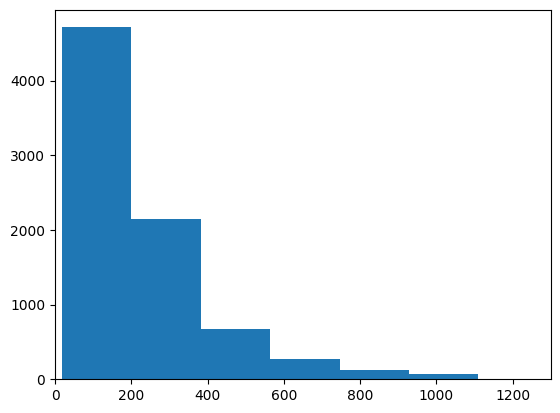

In [17]:
lenght=[]
for i in range(8000):
    len_rev= len(df['text'][i].split())
    lenght.append(len_rev)
plt.hist(lenght)
plt.xlim(-1,1300)

So - we have a lot of reviews - most around the 150-250 word length - and those reviews have a lot of messy punctiation. We could spend a very long time going through and tidying up our text, but the HuggingFace library provides us with `AutoTokenizers` that allow us to quickly and easily convert our text to tokens.

Throughout this notebook, we're going to be working with the `bert-tiny` model from HuggingFace as it's nice and small which means we won't be waiting around for hours for trainings to finish! Why mention this here? Well because it's really important that our __Tokenizer__ and our __model__ align! 

If we want to leverage pre-training, we need to convert our words to tokens and then pass them through the model in a way that our model has seen before. See the diagrams below to see why we need them to match. 

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/tok_emb.png" width = 550px>

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/tok_emb_bad.png" width = 550px>

With that said, instantiate an `AutoTokenizer.from_pretrained()` from HuggingFace that corresponds to the `prajjwal1/bert-tiny` model. 

With HuggingFace, when we load in a tokenizer, if we want to pad to the left or right, we have to mention this when we load it. With BERT, we want our padding to be to the "right" (a.k.a. post-padding) so make sure you pass this key-word argument when you load your model (see the [docs](https://huggingface.co/docs/transformers/v4.33.0/en/model_doc/auto#transformers.AutoTokenizer.from_pretrained.example) for clues on this). Once you've got your tokenizer, use it to produce tokens for this example sentence: 

"My tokenizers and model must match"

In [18]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

In [19]:
tokenizer= AutoTokenizer.from_pretrained('prajjwal1/bert-tiny', padding_side='right')

In [20]:
tokens= tokenizer('My tokenizers and model must match', return_tensors='tf')
tokens

2024-02-11 16:29:53.560365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 16:29:54.140944: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 16:29:54.264226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-11 16:29:54.264248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

{'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101,  2026, 19204, 17629,  2015,  1998,  2944,  2442,  2674,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

To make the point about tokenizers and models needing to fit, run the cell below and see what tokens you get for exactly the same sentence.

In [21]:
llama_tokenizer = AutoTokenizer.from_pretrained("TheBloke/llama-2-70b-Guanaco-QLoRA-fp16")

llama_tokenizer("My tokenizers and model must match")


{'input_ids': [1, 1619, 5993, 19427, 322, 1904, 1818, 1993], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

We see we get out totally different numbers for the `input_ids`!

Another thing you'll notice about __both__ tokenizers is that we get our more tokens than we put in. 

### Why? 

The BERT tokenizer (and many other tokenizers) breaks down input text into smaller units called subwords using "WordPiece" tokenization, enabling the model to handle complex words and capture meaningful subword representations. Loop through your BERT tokens and call the `.decode()` function on them one by one to see how it has broken up the original sentence.

In [22]:
out= [tokenizer.decode(token) for token in tokens[0]]
out

TypeError: 'tokenizers.Encoding' object is not iterable

The tokenizer uses a predefined vocabulary of subwords, assigning each a unique token ID. It also introduces special tokens like `[CLS]` (shows up as 101) and `[SEP]` (shows up as 102) to mark the beginning and separation of sentences for the model. The tokenizer can also handle padding or truncation (cutting up our sentences for us!) so they're a vital part of our pipeline. You'll also see you get out some other keys in this dictionary - `token_type_ids` and `attention_mask` - but we won't worry about them too much for right now!

So now that we have our sentences and our Tokenizer, let's try converting the first sentence in our `df` into tokens.

In [24]:
sentence1=df['text'][0]
token_sent1= tokenizer(sentence1, return_tensors='tf')
token_sent1

{'input_ids': <tf.Tensor: shape=(1, 173), dtype=int32, numpy=
array([[  101, 15068,  2818,   999,  2027,  2123,  1005,  1056,  2272,
         2172,  4788,  2084,  2023,  7570, 18752,  2094,  6789,  1997,
         1039,  1012,  1055,  1012,  4572,  1005,  1055, 11419,  3117,
         1012,  2096,  1996,  6789,  2003,  2200,  2995,  2000,  1996,
         3117,  1010,  1996,  3772,  2003,  3432,  9643,  1998,  1996,
         4520,  1998,  2569,  3896,  2024,  2006,  1037,  4094,  5662,
         2000,  1037,  2082,  2377,  1012,  1045,  1005,  2310,  3191,
         2008,  1996,  5166,  2005,  2023, 13612,  2001,  1996,  9026,
         3367,  2008,  1996,  4035,  2038,  2412,  2445,  2012,  1996,
         2051,  1010,  2021,  7543,  2027,  2071,  2031, 20378,  2362,
         1037,  2978,  2062,  2084,  1996,  1002,  1016,  2008,  2009,
         3504,  2066,  2023,  2001,  6361,  2005,  1012,  1996,  5409,
         3466,  1997,  2035,  2003,  2720,  1012, 13570,  1012,  1045,
         2113, 

### So how can we use a BERT model?

Now that we've explored tokenization, we need to think about how we go from our tokens to somehow getting out a classification of "positive" or "negative" and to do that we need to talk about BERT. If you're looking for a great 10-minute explainer on BERT, you can't go wrong with [Jay Alammar's article](https://jalammar.github.io/illustrated-bert/). The high level view is essentially this, though:

BERT gets trained via "semi-supervised" learning to predict the missing word in a sentence, looking both to its left and right as its context (hence it is named a "bidirectional" encoder). This means that it can see everything on either side of the masked word below.

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/bert_workings.png" width = 350px>



Over time, BERT gets great at filling in the blank - in this case it learns that the word "over" should go here! Let's take a look at some architectures: 

<img src = https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/13789bert_architecture.png width = 500px>

It's literally just an encoder (or the left side of the model we covered in the lecture! GPT is the right side of the model). During training, they add a few Feed Forward layers and a Softmax layer to make the model try to predict the most likely word blanked out:


<img src = https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/transformers_enc_de_bert.png width = 600px>


__"But why does all of this matter? We're not trying to predict a next word here!", you ask!__ Well, because through learning to fill in the blanks millions of times on large datasets, BERT gets a __really__ good understanding of what words mean and how sentences fit together and produces __fantastic, context-aware__ embeddings. 



<img src = https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/bert_good_embeddings_2.png width = 400px>

This is when BERT can become valuable to us - once it's been pre-trained - since we can now take those embedding and use them as __features__ for other tasks.

So - now that you understand our goal - let's see how BERT works in practice.

### Using BERT

Use [`TFAutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel) to load up a `tiny-bert` model. 

N.B. HuggingFace lets us load models that were coded in other Deep Learning libraries (like PyTorch), but if we want to use them like we would use a normal TF model, we can pass `from_pt = True`. 

In [25]:
from transformers import TFAutoModel

In [26]:
model= TFAutoModel.from_pretrained('prajjwal1/bert-tiny', from_pt=True)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  4385920   
                                                                 
Total params: 4,385,920
Trainable params: 4,385,920
Non-trainable params: 0
_________________________________________________________________


How many parameters do we have in our model? Try using the `model.num_parameters()` method to find out!

In [27]:
model.num_parameters()

4385920

To actually get anything out of our model, we need to pass it tensors because that is what it's expecting. With that in mind, let's try using our tokenizer again to create some tensors! Pass the example sentence from above ("My tokenizers and model must match") through your tokenizer again, only this time we're going to add a keyword argument:

`return_tensors` should be set to `"tf"` <br>




In [28]:
tokens= tokenizer('My tokenizers and model must match', return_tensors='tf')
tokens

{'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101,  2026, 19204, 17629,  2015,  1998,  2944,  2442,  2674,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

What do you get out? Check the `type` of the object and look inside it. You can even try casting it to a dictionary

We're now going to pass these into our `model`. Pass your `input_ids` into `model.predict()` method to see what embeddings the model predicts from your input tensor!


In [29]:
import tensorflow as tf

In [30]:
input_tensor= tf.expand_dims(tokens['input_ids'][0], axis=0)
input_tensor

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101,  2026, 19204, 17629,  2015,  1998,  2944,  2442,  2674,
          102]], dtype=int32)>

In [31]:
outputs= model.predict(input_tensor)
outputs

1/1 [==============================] - 3s 3s/step


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=array([[[-1.0925021 ,  0.29617235, -2.7343051 , ..., -1.4312216 ,
         -0.7674911 ,  0.9217779 ],
        [-1.3445785 ,  0.33559626,  0.3213455 , ..., -1.540538  ,
         -1.8095936 ,  1.0475532 ],
        [-0.98489296,  0.04832143, -0.5467527 , ..., -2.799297  ,
         -0.73524225,  1.0017625 ],
        ...,
        [-1.015279  , -0.600632  ,  0.16942331, ..., -2.2654817 ,
         -0.35893232,  0.8517032 ],
        [-1.0218403 ,  0.17833784,  0.30888808, ..., -3.2006292 ,
         -0.19717716,  0.784518  ],
        [-1.2105337 , -0.37066615,  0.09570217, ..., -2.3225179 ,
         -0.45315087,  0.73398167]]], dtype=float32), pooler_output=array([[-0.99999845,  0.14845254, -0.99738866,  0.8437214 , -0.998119  ,
         0.35524368, -0.9906017 , -0.9661024 ,  0.0659069 , -0.00468243,
        -0.87718135, -0.13842532,  0.01992583,  0.999998  ,  0.28008857,
        -0.93008614,  0.9557761 ,  0.13612919, -0.4902352 ,

In [32]:
input_tensor.shape

TensorShape([1, 10])

The part we care about most is the `last_hidden_state` array from our prediction. This contains all of our embeddings from the final layer of the BERT model. What is its shape? What does each aspect of the shape signify?

In [33]:
outputs.last_hidden_state.shape

(1, 10, 128)

You should have a shape of __(1, 10, 128)__. Why? 

The batch size is 1.
We have 10 tokens. 
Each token has a 128-long embeddings since Tiny Bert has a "hidden size" of 128 which means it'll create embeddings of that size.

Run the cell below to load up `bert-small` instead of `tiny-bert` and check the model description you see listed on HuggingFace. You should see a different "hidden_dimension" size reflected in the embeddings you get out when you `.predict()` on the same sentence.

In [34]:
small_model = TFAutoModel.from_pretrained("prajjwal1/bert-small", from_pt = True)
small_model.predict(input_tensor).last_hidden_state.shape

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

1/1 [==============================] - 1s 908ms/step


(1, 10, 512)

When we're using our embeddings as a feature, we usually don't need to take out all 10 tokens out - we usually just take the first token (the `[CLS]` token that gets inserted for us) out instead - this should contain most of the information from our full sentence. With that in mind, select just the final token from your `bert_tiny` embeddings. It should have shape (1, 128)

In [67]:
outputs.last_hidden_state[:,0,:]

array([[-1.0925021 ,  0.29617235, -2.7343051 , -2.2203484 ,  0.2302205 ,
         1.4071054 , -0.2047798 ,  1.335129  , -0.2827275 ,  0.20631815,
        -0.73093116,  1.1392698 , -0.82592785,  1.0474565 ,  1.6219755 ,
        -0.51183206, -0.61848944, -0.5063367 , -1.7092572 ,  1.2861506 ,
         0.01437919, -0.95187956,  1.9190152 , -0.09677979,  1.6345795 ,
        -0.65476596, -0.05932965,  0.8851405 , -0.06017072,  0.04003938,
        -1.0718913 , -1.4089686 , -1.9967726 , -0.05314662,  0.13098368,
        -1.9281592 , -0.530232  , -1.2534158 , -1.5812123 , -1.1570289 ,
         0.14575572, -0.00787837,  1.9595453 , -0.8199371 , -0.00376356,
        -1.9050608 ,  1.1575568 , -0.97217214,  0.12068213, -0.44845968,
         0.04000355,  2.1770945 ,  0.52306753, -0.24064335,  0.0562015 ,
        -0.37357658,  0.38304362, -0.10185967, -0.87340087,  3.0557742 ,
         1.548567  , -0.7458633 , -0.6536311 , -2.119369  , -1.4256177 ,
         0.30889928, -0.2581733 ,  0.50396174,  0.7

### Tokenizing all our sentences

We want to tokenize all of the cells in our "text" column at once. Before we do though, we need to think about padding. Because we're using subwork tokenization, we can't simply pad/ truncate our words when they are written out in full text. For example:

"Transformer models do a lot of good things"

"Although indubitably complex, Transformers outperform countless other models"

Both of these sentence are 8 words long. But when we use subword tokenization, the second one will be split into more tokens, since it contains much longer words.

Check the length of both of these sentences tokenized to provide this to yourself.

In [36]:
sent1_toks = tokenizer("Transformer models do a lot of good things")

sent2_toks = tokenizer("Although indubitably complex, Transformers outperform countless other models")

print(len(sent1_toks["input_ids"]))
print(len(sent2_toks["input_ids"]))


11
16


We want to see how long our tokenized sentences will all be, then we can make a decision about how we should pad/ truncate our sentences.

We'll need to go through each sentence in our DataFrame and see how long it is when tokenized (we can do this by mapping/ applying a function on our DataFrame that tokenizes our sentences). Then we can simply do a quick histogram to see what our varying lengths look like.

<AxesSubplot:>

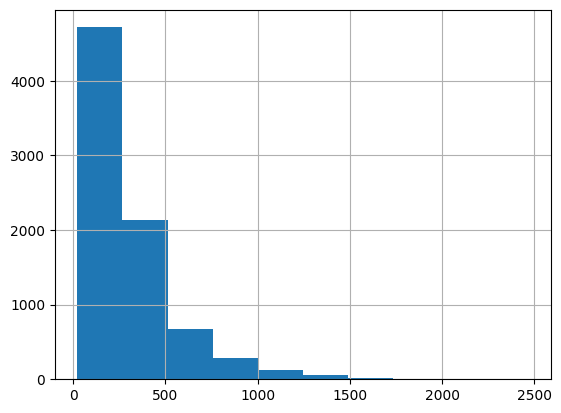

In [37]:
df["tokenized"] = df["text"].map(lambda x: tokenizer(x)["input_ids"])

df["len_tokenized"] = df["tokenized"].map(lambda x: len(x))

df["len_tokenized"].hist()

Looking at our histogram, 500 seems like a reasonable choice.

Let's go ahead and tokenize our column - specify your `"max_length"` as 500 and make sure you enable padding as you call your tokenizer. To get this to work properly, you'll also need to set a value of `True` for the `truncation` arguments and you'll need to make sure you set `padding` equal to `"max_length"`. To ensure the model gets the right kind of input, you will have to add `.tolist()` when you pass your column into your tokenizer.

In [38]:
tokenized_tensors= tokenizer(df['text'].tolist(), max_length=500, padding='max_length', truncation=True,return_tensors='tf')

What do we get out? What shape do its components have?


In [39]:
tokenized_tensors['input_ids'].shape

TensorShape([8000, 500])

Again, we're just interested in our `input_ids` for now (we won't worry about the attention mask). So grab those and use `model.predict()` to see what embeddings we get out for all of our tokenized sentences.

In [40]:
embeddings= model.predict(tokenized_tensors['input_ids'])

250/250 [==============================] - 59s 233ms/step


In [41]:
embeddings.last_hidden_state.shape

(8000, 500, 128)

### Reducing our data

We finally have all of our sentence embeddings - 128 numbers to express each of our words in their context. This might be quite a lot of data for a model to process (especially if we were to scale up) so we'll simply take the embedding corresponding to the `[CLS]` token (i.e. the first token of your sequence). 


<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/CLS_token_explanation.png"> Select this column from your `last_hidden_state` and assign it to `X` since this is what we're going to use in our Classification Neural Network. 

In [42]:
X= embeddings.last_hidden_state[:,0,:]

In [43]:
X.shape

(8000, 128)

Now, create a train-test split, and train a simple Dense Network to classify between positive and negative reviews. Train it, then evaluate your model on the test set. What kind of accuracy do you get?

In [44]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [45]:
X_train, X_test, y_train, y_test= train_test_split(X, df['label'])

In [46]:
input_shape= (128,)
dens_model= Sequential()
dens_model.add(Dense(256, activation='relu', input_shape= input_shape))
dens_model.add(Flatten())
dens_model.add(Dense(1, activation='sigmoid'))

dens_model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics='accuracy')

In [47]:
dens_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33,281
Trainable params: 33,281
Non-trainable params: 0
_________________________________________________________________


In [48]:
dens_model.fit(X_train, y_train, validation_split=0.2, epochs= 20)

Epoch 1/20
150/150 [==============================] - 3s 3ms/step - loss: 0.6096 - accuracy: 0.6581 - val_loss: 0.6157 - val_accuracy: 0.6717
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5518 - accuracy: 0.7154 - val_loss: 0.5429 - val_accuracy: 0.7292
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5361 - accuracy: 0.7348 - val_loss: 0.5384 - val_accuracy: 0.7283
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5291 - accuracy: 0.7354 - val_loss: 0.5529 - val_accuracy: 0.7192
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5186 - accuracy: 0.7498 - val_loss: 0.5701 - val_accuracy: 0.7083
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.5192 - accuracy: 0.7390 - val_loss: 0.5420 - val_accuracy: 0.7233
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5096 - accuracy: 0.7454 - val_loss: 0.5255 - val_accuracy: 0.7450
Epoch 

In [49]:
dens_model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.5741 - accuracy: 0.7300


[0.5740604996681213, 0.7300000190734863]

Looks like we get around 70% which isn't too bad, but could we do any better?

### Fine tuning a BERT model for our task

In the first part of our exercise, we've just been passing our data through a pre-trained BERT model. That means that we've just been using the weights that were achieved by training the model on its training dataset, but the interpretation that the BERT model might have for each word could be different - consider the following words:

"The direction was completely unique"

This sentence might mean very different things (and thus give different embeddings) to a model that has been trained on text about the weather (e.g. the model might interpret this as something to do with the "direction" of the wind or an ocean current). But means something completely different when it comes to talking about the "direction" of a film director. We're dealing with a dataset about movies and that may contain a lot of words and concepts that are very unfamiliar to our regular BERT model.

So we have a problem! The embeddings that we're getting out may not be suited too well to our task so we're limited in how well our model can interpret our words since we we're stuck with potentially unhelpful embeddings.

But what if we could let the model learn as it goes? What if we could take those existing, excellent weights and change them __slightly__ so that they perform perfectly for our task at hand?





<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/bert_weight_updating_2.png">

This is exactly what __fine-tuning__ is and HuggingFace makes it really easy 😇

Create another `tiny-bert` model, loading it up with [`TFAutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelforsequenceclassification) this time instead. 

In [50]:
from transformers import TFAutoModelForSequenceClassification

In [58]:
tuning_model= TFAutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All we need to do is pass in our tensors that represent out tokenized sentences that we created earlier. We can split off 20% of our data for our test. Then pass our tensors of tokens and our labels straight into our model.

In [59]:
tokenized_tensors['input_ids'].shape

TensorShape([8000, 500])

In [60]:
X_train= tokenized_tensors['input_ids'][:6400]
X_test= tokenized_tensors['input_ids'][6400:]
y_train= df['label'][:6400]
y_test= df['label'][6400:]

Set a very low number of epochs for your training such as 3 or 5 - why? Well now we're updating over __4 million weights at once__ which takes a lot of time and computational power. 😮‍💨 Much more than the small Dense network we put on top of our X and y in the first half of the exercise. We should see good results after only a few epochs, though! 


While you wait for training to finish, you can take the time to dig a little deeper into [BERT's architecture](https://jalammar.github.io/illustrated-bert/). 


In [61]:
tuning_model.compile(optimizer= "adam", metrics= "accuracy")

In [62]:
tuning_model.fit(tokenized_tensors["input_ids"], df["label"], validation_split=0.2, batch_size=32, epochs=5)

Epoch 1/5
200/200 [==============================] - 231s 1s/step - loss: 0.6221 - accuracy: 0.6212 - val_loss: 0.5110 - val_accuracy: 0.7769
Epoch 2/5
200/200 [==============================] - 209s 1s/step - loss: 0.4045 - accuracy: 0.8273 - val_loss: 0.3974 - val_accuracy: 0.8275
Epoch 3/5
200/200 [==============================] - 266s 1s/step - loss: 0.2430 - accuracy: 0.9028 - val_loss: 0.3946 - val_accuracy: 0.8413
Epoch 4/5
200/200 [==============================] - 231s 1s/step - loss: 0.0995 - accuracy: 0.9694 - val_loss: 0.6475 - val_accuracy: 0.8156
Epoch 5/5
200/200 [==============================] - 235s 1s/step - loss: 0.0452 - accuracy: 0.9866 - val_loss: 0.5539 - val_accuracy: 0.8400


In [55]:
tuning_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  4385920   
                                                                 
 dropout_27 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  258       
                                                                 
Total params: 4,386,178
Trainable params: 4,386,178
Non-trainable params: 0
_________________________________________________________________


Once your model has trained for a few epochs, try increasing your learning rate by switching your optimizer. Simply instantiate an instance of the Adam class from `tf.keras.optimizers` and try increasing it from the default. 

When we're working with such enormous models, updating weights can take a very long time but increasing our learning rate should yield better results much faster. 

In [56]:
optimizer = tf.optimizers.Adam(learning_rate=0.1)
fast_model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", from_pt = True)

fast_model.compile(optimizer= optimizer, metrics= "accuracy")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
fast_model.fit(tokenized_tensors["input_ids"], df["label"], validation_split=0.2, batch_size=32, epochs=2)

Epoch 1/2
200/200 [==============================] - 168s 831ms/step - loss: 1.2096 - accuracy: 0.5053 - val_loss: 0.9451 - val_accuracy: 0.5019
Epoch 2/2
200/200 [==============================] - 210s 1s/step - loss: 1.4039 - accuracy: 0.4908 - val_loss: 1.2754 - val_accuracy: 0.4981


Evaluate your results on your test set! You should see that when we take the tune a model __specifically__ for our task, we get better results even after just 3-4 epochs of training.

Congratulations! You've just fine-tuned your own LLM 🎉🎉🎉

### Some important notes:

- We're getting good results with this model but this is a *tiny* version of BERT. If we increased the size of our model and if we used our full dataset (rather than just 5000 samples), we might get even better results. 

- One downside of fine-tuning (as you have seen) is that it can take a LOT of computational power to carry out. Imagine how much more it might take if we didn't start off with our transfer-learned weights.

- Because of that, in can be important to consider other options first - if you'd like, try training a regular ML Tfidf model and you may be surprised how good the results are. When we're dealing with tasks like classification, __ML will often do a pretty good job with much less compute!__

- That said, there are a __very wide__ range of use cases for BERT-style models - we've only done classification here! Look around HuggingFace and you'll see all sorts of fine-tuned BERTs for specific domains (e.g. Finance, medicine or Twitter) and different tasks (some that ML can't help us with)

- Each BERT model can be fine-tuned as long as you take the proper time to structure your data correctly (especially using Data Loaders like the Tensorflow Dataset if your data is very large). 

Now that you've seen what can be done with an encoder-style model, it's time to see what a decoder-style model looks like 🚀